# 9. 성능 개선
## 9.1. 과적합 - Early stopping

Early stopping을 사용할때는 테스트 데이터에는 적용하면 안된다. 일종의 치팅이됨.
또한, 얼리 스탑핑은 검증 데이터셋을 기준으로 하기 때문에, 테스트 데이터셋에서와는 조금 다를 수 있다.
얼리 스탑핑을 통해서 얻은 로스가 최적의 로스가 아닐 수도 있다. 실제로 레즈넷 논문에서는 스케줄링 기법등을 활용해, 로스에 변화가 없다가도 더 많은 에폭을 훈련한 후에 성능이 개선되기도 했다.


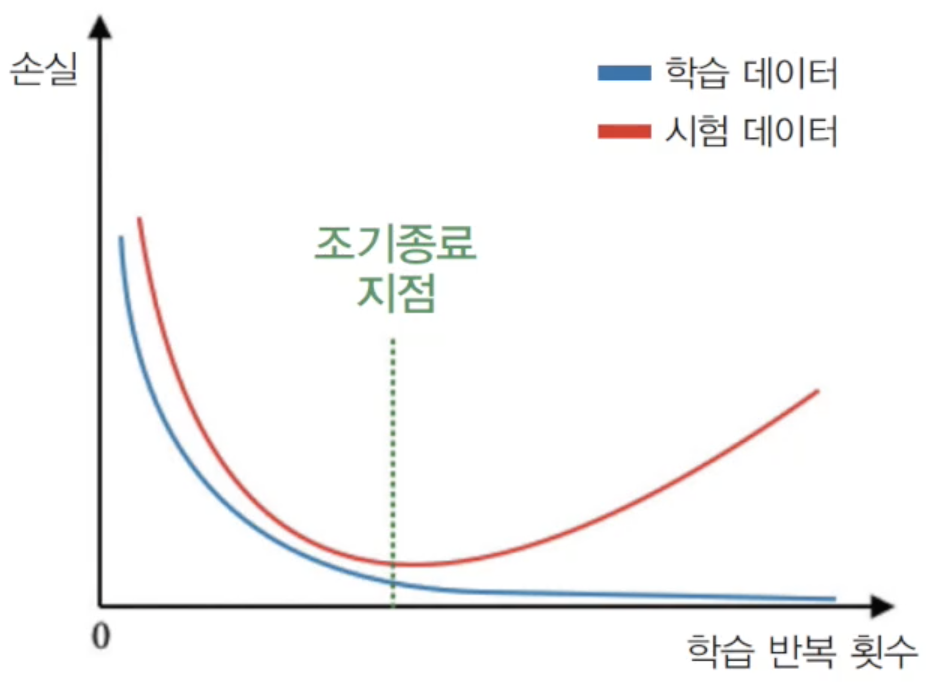

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd/content/drive/MyDrive/Pytorch Basic/deeplearningbro/pytorch

/content/drive/MyDrive/Pytorch Basic/deeplearningbro/pytorch


In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainset, valset = torch.utils.data.random_split(dataset, [30000, 20000]) # 트레인, 벨리데이션 스플릿

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True) 
valloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False) 

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# CPU/GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available.')

cuda:0 is available.


In [6]:
#ResNet
class ResidualBlock(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.stride = stride
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.conv_block = nn.Sequential(nn.Conv2d(self.in_channels, self.out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
                                        nn.BatchNorm2d(self.out_channels),
                                        nn.ReLU(),
                                        nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=1, bias=False),
                                        nn.BatchNorm2d(self.out_channels))

        if self.stride != 1 or self.in_channels != self.out_channels:
            self.downsample = nn.Sequential(nn.Conv2d(self.in_channels, self.out_channels, kernel_size=1, stride=stride, bias=False),
                                            nn.BatchNorm2d(self.out_channels))

    def forward(self, x):
        out = self.conv_block(x)
        if self.stride != 1 or self.in_channels != self.out_channels:
            x = self.downsample(x)

        out = F.relu(x + out)
        return out

In [7]:
class ResNet(nn.Module):
    def __init__(self, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.base = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size=3,stride=1, padding=1, bias=False),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.layer1 = self._make_layer(64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(512, num_blocks[3], stride=2)
        self.gap = nn.AvgPool2d(4) # 4: 필터 사이즈
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride):
        
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            block = ResidualBlock(self.in_channels, out_channels, stride)
            layers.append(block)
            self.in_channels = out_channels
    
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.base(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.gap(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

def modeltype(model):
    if model == 'resnet18':
        return ResNet([2, 2, 2, 2])

    elif model == 'resnet34':
        return ResNet([3, 4, 6, 3])



In [8]:
resnet = modeltype('resnet18').to(device)

In [9]:
#print(resnet)
PATH = './models/test_cifar_resnet_early.pth' # 모델 저장 경로 

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=1e-3)

In [11]:
def validation_loss(dataloader):
    n = len(dataloader)
    running_loss = 0.0
    with torch.no_grad():
        resnet.eval() # 검증으로 바꿨다가.
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = resnet(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    resnet.train() # 트레인으로 다시 바꿔야한다. 학습 중간중간 확인하고 다시 실행해야하기 때문
    return running_loss / n

In [12]:
train_loss_list = [] # 그래프를 그리기 위한 loss 저장용 리스트 
val_loss_list = []
n = len(trainloader) # 배치 개수
early_stopping_loss = 1
for epoch in range(51): 

    running_loss = 0.0
    for data in trainloader:

        inputs, labels = data[0].to(device), data[1].to(device) # 배치 데이터 
        
        optimizer.zero_grad()
        outputs = resnet(inputs) # 예측값 산출 
        loss = criterion(outputs, labels) # 손실함수 계산
        loss.backward() # 손실함수 기준으로 역전파 선언
        optimizer.step() # 가중치 최적화

        # print statistics
        running_loss += loss.item()

    train_loss = running_loss / n
    train_loss_list.append(train_loss)    
    val_loss = validation_loss(valloader)
    val_loss_list.append(val_loss)
    
    print('[%d] train loss: %.3f , validation loss: %.3f' %(epoch + 1, train_loss, val_loss))
    
    if val_loss < early_stopping_loss:
        torch.save(resnet.state_dict(), PATH)
        early_stopping_train_loss = train_loss
        early_stopping_val_loss = val_loss
        early_stopping_epoch = epoch
        
print('Final pretrained model >> [%d] train loss: %.3f , validation loss: %.3f' %(early_stopping_epoch + 1, 
                                                        early_stopping_train_loss, early_stopping_val_loss))


[1] train loss: 1.473 , validation loss: 1.649
[2] train loss: 1.004 , validation loss: 1.068
[3] train loss: 0.786 , validation loss: 0.736
[4] train loss: 0.619 , validation loss: 0.751
[5] train loss: 0.502 , validation loss: 0.717
[6] train loss: 0.388 , validation loss: 0.654
[7] train loss: 0.289 , validation loss: 0.803
[8] train loss: 0.199 , validation loss: 0.731
[9] train loss: 0.156 , validation loss: 0.798
[10] train loss: 0.111 , validation loss: 0.763
[11] train loss: 0.093 , validation loss: 0.821
[12] train loss: 0.084 , validation loss: 0.818
[13] train loss: 0.064 , validation loss: 0.941
[14] train loss: 0.068 , validation loss: 0.924
[15] train loss: 0.060 , validation loss: 1.064
[16] train loss: 0.048 , validation loss: 0.975
[17] train loss: 0.052 , validation loss: 0.945
[18] train loss: 0.040 , validation loss: 1.005
[19] train loss: 0.045 , validation loss: 0.974
[20] train loss: 0.041 , validation loss: 0.944
[21] train loss: 0.041 , validation loss: 0.965
[

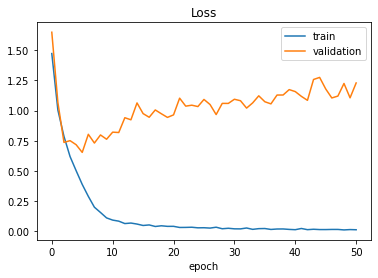

In [13]:
plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.legend(['train','validation'])
plt.title("Loss")
plt.xlabel("epoch")
plt.show()

In [14]:
# 베스트 모델로 저장된 파라미터를 불러온다.
resnet = modeltype('resnet18').to(device)
resnet.load_state_dict(torch.load(PATH)) # 모델 파라메타 불러오기

<All keys matched successfully>

In [15]:
# 평가 데이터를 이용해 정확도를 구해보자.
# output은 미니배치의 결과가 산출되기 때문에 for문을 통해서 test 전체의 예측값을 구한다.

correct = 0
total = 0
with torch.no_grad():
    resnet.eval()
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) # 개수 누적(총 개수)
        correct += (predicted == labels).sum().item() # 누적(맞으면 1, 틀리면 0으로 합산)
        
print('Test accuracy: %.2f %%' % (100 * correct / total))

# ResNet (overfitting): 75.57 %
# ResNet (ealy stopping): 76.22 %

Test accuracy: 81.16 %
